In [1]:
import time
import datetime
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# NN model definition

In [2]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            if output.dim()<3:
                output=output.unsqueeze(1)
            h_t, c_t = self.lstm(output.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs


In [3]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=4,
        n_epochs=100,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)
            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

# Auxilliary functions

In [4]:
# Build index in order to transform data into time series
def dateindex_from_weeknum(weeknum, year):
    if weeknum == 1:
        date_str = "" + str(year) + "-01-01"
        dateindex = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    else:
        date_str = "" + str(year) + "-W" + str(weeknum-1) + "-1"
        dateindex = datetime.datetime.strptime(date_str, "%Y-W%W-%w")

    return dateindex

# Load and clean data

In [5]:
## STORE DATA

# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/BUSNA.csv"))
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/PAVIA.csv"))

# Turin data
turin_data_df = pd.read_csv("../datasets/dati_nunalie/TORINO/BEINA.csv")
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/NICHE.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TODOR.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TORIN.csv"))

# Rome data
rome_data_df = pd.read_csv("../datasets/dati_nunalie/ROMA/EURR2.csv")
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/RMNAZ.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TIBUR.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC1.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC2.csv"))

print("Milan sales data")
print(milan_data_df.head())
print("\n")
print("Turin sales data")
print(turin_data_df.head())
print("\n")
print("Rome sales data")
print(rome_data_df.head())
print("\n\n")


## EXOGENOUS DATA

# weather
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv")
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv")

# population
milan_pop_df = pd.read_csv("../datasets/Eso_data/population/milano_population_data.csv")
turin_pop_df = pd.read_csv("../datasets/Eso_data/population/torino_population_data.csv")
rome_pop_df = pd.read_csv("../datasets/Eso_data/population/roma_population_data.csv")

Milan sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0        8313  16SF181BNE-16        1         16  2016     XS   ARESE     LSI
1        8511  VA515233NE-16        1         16  2016     XS   ARESE     LSI
2        8569  16SF181BBL-16        1         16  2016      S   ARESE     LSI
3        8807   ZR121FABI-16        2         16  2016     UN   ARESE     LSI
4        8833  16SF181BNE-16        1         16  2016      S   ARESE     LSI


Turin sales data
   Unnamed: 0  codice esterno  vendita  settimana  anno taglia negozio listino
0      652733    2201611NE-17        1         19  2017      M   BEINA     LSI
1      653618        TS4BE-17        1         19  2017      S   BEINA     LSI
2      653750        TS4BE-17        1         19  2017      M   BEINA     LSI
3      653776  30038PE17BL-17        1         20  2017     38   BEINA     LSI
4      653867       BY19RS-17        1         20  2017     UN   BEINA     LSI


Rome sales data
   U

In [6]:
def augment_store_data (store_df, loc_weather_df, loc_pop_df):
    ## PREPROCESS THE ORIGINAL STORE DATA
    
    # Drop unnamed column and listino column, we won't be using those
    store_df = store_df.drop(["Unnamed: 0", "listino"], axis=1)

    # Build datetime index
    store_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in store_df[["settimana", "anno"]].values]
    store_df = store_df.set_index(["time"])
    store_df.index = pd.to_datetime(store_df.index) # make ts

    # Sort the data based on the new time index
    store_df.sort_index(inplace=True)

    # Aggregate the data to get the total sales of each week
    store_weekly_totals = store_df.groupby(pd.Grouper(freq = "W-MON")).agg({
        "vendita": np.sum,
        "settimana": np.min, 
        "anno": np.min,
    })

    # Check for NAN values and replace them if they are present
    nan_indices = store_weekly_totals[store_weekly_totals.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        store_weekly_totals.loc[nan_idx, "vendita"] = np.mean(store_weekly_totals.loc[:nan_idx,"vendita"].values)
        store_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
        store_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
        
    # Drop 2020 data (we won't be using them)
    store_weekly_totals.drop(store_weekly_totals.loc["2020"].index, inplace=True)
    
    ## PREPROCESS AND ADD WEATHER DATA
    
    # Converting the index as datetime index
    loc_weather_df = loc_weather_df.set_index(["DATA"])
    loc_weather_df.index = pd.to_datetime(loc_weather_df.index) # make ts

    # We can't really group the different weather fenomenons happening each day that column can't be used
    # Also the rain and average pressure cols are useless, they only have values of 0 or nan.
    # We won't be using those either 
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    # Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
    loc_weather_df = loc_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
    loc_weather_df = loc_weather_df.fillna(0).astype(int)

    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_weekly_weather_augmented = store_weekly_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_weekly_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
        
    
    ## PREPROCESS AND ADD POPULATION DATA
    
    # At first we'll just be using the total population value for each city
    total_loc_population = loc_pop_df.Value.sum()
    store_weekly_weather_augmented["pop"] = total_loc_population
    
    return store_weekly_totals, store_weekly_weather_augmented

In [7]:
# Augment single location sales data and then put everything together
milan_weekly_default, milan_weekly_augmented = augment_store_data(milan_data_df, milan_weather_df, milan_pop_df)
print("Milan data shape:", milan_weekly_augmented.shape)
turin_weekly_default, turin_weekly_augmented = augment_store_data(turin_data_df, turin_weather_df, turin_pop_df)
print("Turin data shape:", turin_weekly_augmented.shape)
rome_weekly_default, rome_weekly_augmented = augment_store_data(rome_data_df, rome_weather_df, rome_pop_df)
print("Rome data shape:", rome_weekly_augmented.shape)
#global_weekly_sales_augmented = milan_weekly_augmented.append(turin_weekly_augmented)
#global_weekly_sales_augmented = global_weekly_sales_augmented.append(rome_weekly_augmented)
#print("All together:", global_weekly_sales_augmented.shape)
#global_weekly_sales_augmented.sort_index(inplace=True)

Milan data shape: (195, 14)
Turin data shape: (199, 14)
Rome data shape: (200, 14)


In [17]:
## Create dicts for different store data
def_datasets = {
    "Milan": milan_weekly_default,
    "Turin": turin_weekly_default, 
    "Rome": rome_weekly_default
}
aug_datasets = {
    "Milan": milan_weekly_augmented,
    "Turin": turin_weekly_augmented, 
    "Rome": rome_weekly_augmented
}

Sales and temporal data for Milan


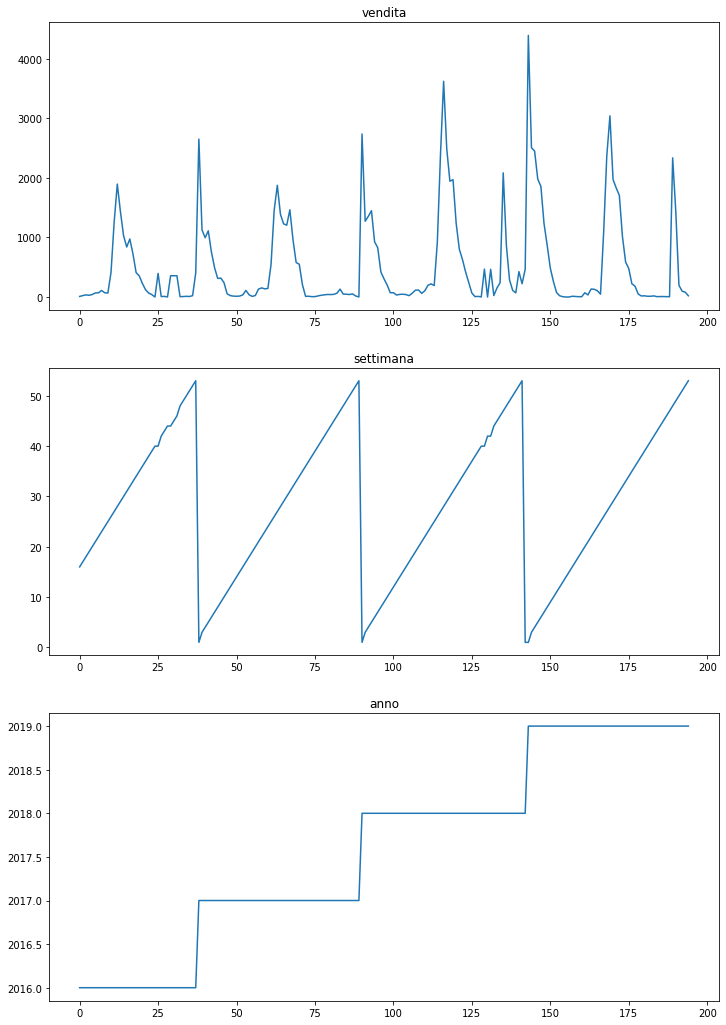

In [9]:
# Plot the data to explore and see what we are working with
for dataset in aug_datasets:
    print("Sales and temporal data for", dataset)
    
    values = aug_datasets[dataset].values
    cols_to_plot = [0,1,2]
    i=1
    plt.figure(figsize=(12,18))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col])
        plt.title(aug_datasets[dataset].columns[col], loc="center")
        i += 1
    plt.show()

## Prepare data for the LSTM Network

In [10]:
def ts_train_test_split(df, test_length=0.2):
    # Perform train-test split
    split_index = int(df.shape[0]*test_length)
    train = df[:-split_index]
    test = df[-split_index:]    
    return train, test

In [11]:
def prepare_for_network(train, test):
    # Build the full training and testing dataframes
    #tr_df_denorm = pd.DataFrame(train.values, index=train.index.values, dtype=np.float32, columns=train.columns)
    #te_df_denorm = pd.DataFrame(test.values, index=test.index.values, dtype=np.float32, columns=test.columns)

    # In order to pass the data to the LSTM we need to transform it so it is in the range [-1,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    for col in tr_df.columns:
        #print(tr_df.loc[:, col])
        # mean std Z standardization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std
        
    
    return tr_df, te_df

In [12]:
def build_in_out_seq(tr_df, te_df, desired_input_features):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.

    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(4, 16)], axis=1)[16:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(4)], axis=1)[16:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(4, 16)], axis=1)[16:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(4)], axis=1)[16:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [13]:
def cols_with_most_corr(corr_matrix, forecast_target_col, corr_threshhold=0.10):
    corrmat_row = corr_matrix.iloc[forecast_target_col, :]
    corrmat_row_vals = corrmat_row.values.tolist()
    # Get only the columns that have a correlation coefficient >= corr_threshhold or =< -corr_threshhold
    correlated_features = []
    for val in corrmat_row_vals:
        if (val > corr_threshhold or val < -corr_threshhold):
            correlated_features.append(corrmat_row_vals.index(val))
    return correlated_features

In [14]:
def check_forecast_results(pred, inp_te, out_te, poll_mean, poll_std):
    # *Data back needs to rescaled back to normal*
    plt.title("One step forecast for first 23 test out entries")
    plt.plot(range(0,23),out_te[:23,0,0]*poll_std+poll_mean,label="GT")
    plt.plot(range(0,23),pred[:23,-4,0].detach().cpu().numpy()*poll_std+poll_mean,label="Predictions")
    plt.legend()
    plt.show()

    plt.title("Forecast of 4 weeks (~ 1 month) given 12 (~ 3 months)")
    #plt.plot(range(0,16),np.concatenate((inp_te[0,:,0],out_te[0,:,0]),0)*poll_std+poll_mean,label="GT")
    plt.plot(range(0,4),(out_te[0, :,0] * poll_std) + poll_mean,label="GT")
    plt.plot(range(0,4),pred[0,-4:,0].detach().cpu().numpy()*poll_std+poll_mean,label="Forecast")
    plt.legend()
    plt.show()

    # Numerical evaluation based on RMSE and MAE 
    rmse = sm.tools.eval_measures.rmse((pred[:, -4,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
    mae = sm.tools.eval_measures.meanabs((pred[:, -4,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
    print("RMSE value:", rmse)
    print("MAE value:", mae)
    return rmse, mae

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Default training and test sets dimensions:
 (156, 3) (39, 3)
Augmented training and test sets dimensions:
 (156, 14) (39, 14)


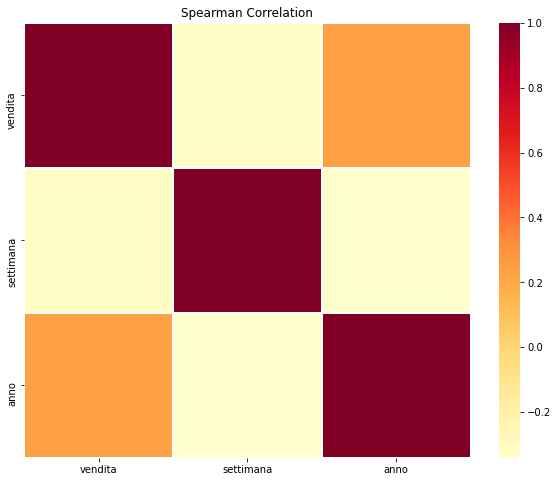

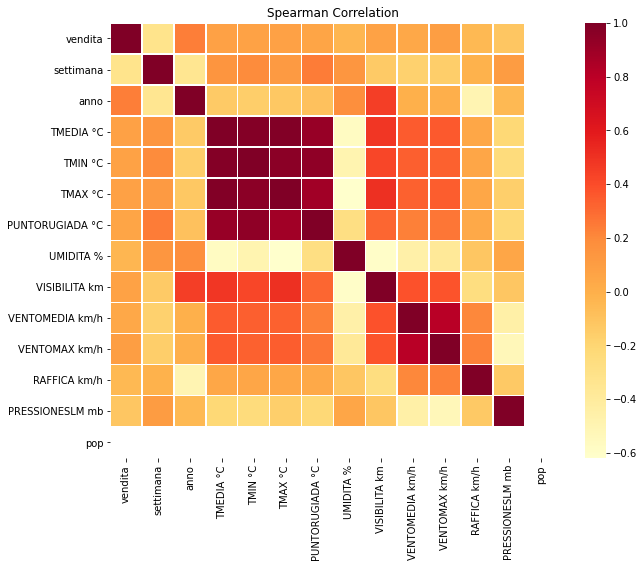

Default input features: [0, 1, 2]
Input features with augmented data: [0, 1, 2, 10, 12]
Inputs for training
(140, 12, 3)
Outputs for training
(140, 4, 3)
Inputs for testing
(23, 12, 3)
Outputs for testing
(23, 4, 3)


Inputs for training
(140, 12, 5)
Outputs for training
(140, 4, 5)
Inputs for testing
(23, 12, 5)
Outputs for testing
(23, 4, 5)



Training the default model
Epoch 1 Train loss: 0.89. Validation loss: 0.76. Avg future: 4.03. Elapsed time: 0.53s.
Epoch 2 Train loss: 0.69. Validation loss: 0.58. Avg future: 3.74. Elapsed time: 0.47s.
Epoch 3 Train loss: 0.52. Validation loss: 0.43. Avg future: 3.97. Elapsed time: 0.45s.
Epoch 4 Train loss: 0.42. Validation loss: 0.43. Avg future: 4.00. Elapsed time: 0.65s.
Epoch 5 Train loss: 0.39. Validation loss: 0.36. Avg future: 4.41. Elapsed time: 0.53s.
Epoch 6 Train loss: 0.37. Validation loss: 0.32. Avg future: 4.24. Elapsed time: 0.50s.
Epoch 7 Train loss: 0.32. Validation loss: 0.30. Avg future: 3.91. Elapsed time: 0.47s.
Epoch 8 

Epoch 39 Train loss: 0.39. Validation loss: 0.40. Avg future: 3.56. Elapsed time: 0.47s.
Epoch 40 Train loss: 0.39. Validation loss: 0.39. Avg future: 4.15. Elapsed time: 0.43s.
Epoch 41 Train loss: 0.39. Validation loss: 0.39. Avg future: 4.35. Elapsed time: 0.44s.
Epoch 42 Train loss: 0.40. Validation loss: 0.39. Avg future: 3.97. Elapsed time: 0.45s.
Epoch 43 Train loss: 0.39. Validation loss: 0.39. Avg future: 4.12. Elapsed time: 0.45s.
Epoch 44 Train loss: 0.39. Validation loss: 0.39. Avg future: 4.38. Elapsed time: 0.46s.
Epoch 45 Train loss: 0.39. Validation loss: 0.39. Avg future: 3.59. Elapsed time: 0.46s.
Epoch 46 Train loss: 0.39. Validation loss: 0.39. Avg future: 3.47. Elapsed time: 0.47s.
Epoch 47 Train loss: 0.39. Validation loss: 0.39. Avg future: 4.68. Elapsed time: 0.44s.
Epoch 48 Train loss: 0.39. Validation loss: 0.39. Avg future: 3.88. Elapsed time: 0.43s.
Epoch 49 Train loss: 0.38. Validation loss: 0.39. Avg future: 4.85. Elapsed time: 0.45s.
Epoch 50 Train loss: 

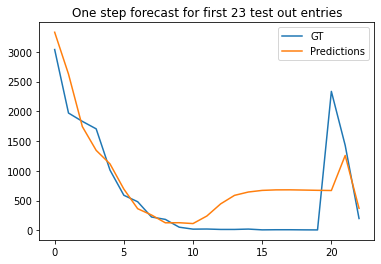

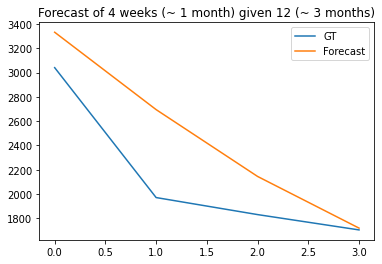

RMSE value: 540.803052333852
MAE value: 398.9249108355978


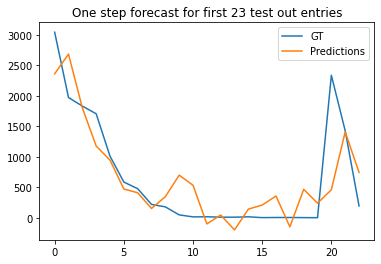

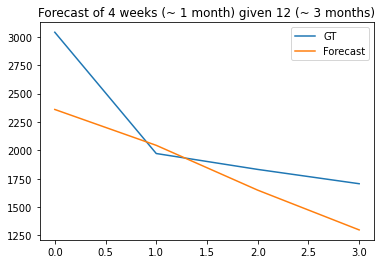

RMSE value: 524.7893005787864
MAE value: 344.77616417926293
Default training and test sets dimensions:
 (160, 3) (39, 3)
Augmented training and test sets dimensions:
 (160, 14) (39, 14)


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


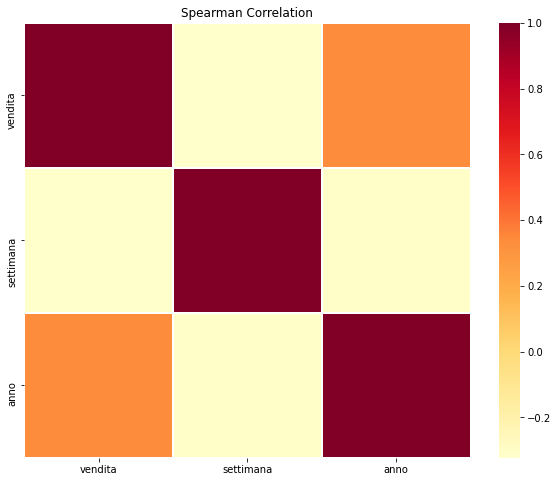

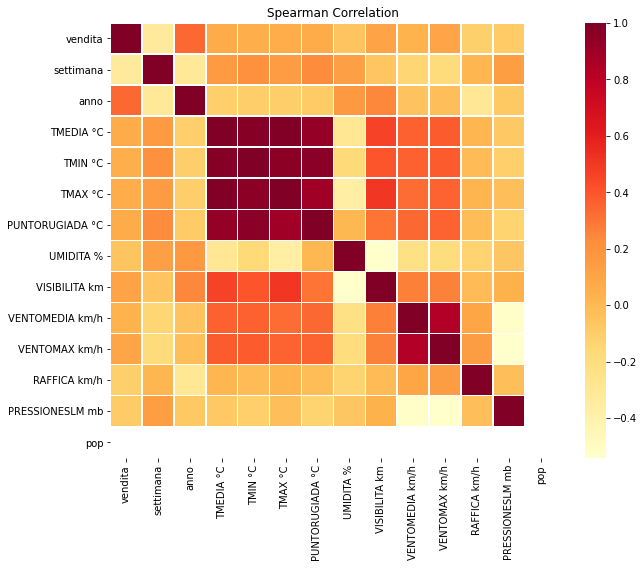

Default input features: [0, 1, 2]
Input features with augmented data: [0, 1, 2, 8, 10, 11]
Inputs for training
(144, 12, 3)
Outputs for training
(144, 4, 3)
Inputs for testing
(23, 12, 3)
Outputs for testing
(23, 4, 3)


Inputs for training
(144, 12, 6)
Outputs for training
(144, 4, 6)
Inputs for testing
(23, 12, 6)
Outputs for testing
(23, 4, 6)



Training the default model
Epoch 1 Train loss: 0.87. Validation loss: 0.71. Avg future: 3.51. Elapsed time: 0.45s.
Epoch 2 Train loss: 0.64. Validation loss: 0.51. Avg future: 4.46. Elapsed time: 0.47s.
Epoch 3 Train loss: 0.47. Validation loss: 0.39. Avg future: 4.09. Elapsed time: 0.47s.
Epoch 4 Train loss: 0.37. Validation loss: 0.32. Avg future: 3.94. Elapsed time: 0.48s.
Epoch 5 Train loss: 0.31. Validation loss: 0.29. Avg future: 4.09. Elapsed time: 0.47s.
Epoch 6 Train loss: 0.28. Validation loss: 0.29. Avg future: 4.34. Elapsed time: 0.46s.
Epoch 7 Train loss: 0.30. Validation loss: 0.28. Avg future: 4.43. Elapsed time: 0.45s.
Epoch

Epoch 39 Train loss: 0.36. Validation loss: 0.36. Avg future: 3.89. Elapsed time: 0.47s.
Epoch 40 Train loss: 0.36. Validation loss: 0.36. Avg future: 4.31. Elapsed time: 0.46s.
Epoch 41 Train loss: 0.36. Validation loss: 0.36. Avg future: 4.26. Elapsed time: 0.48s.
Epoch 42 Train loss: 0.36. Validation loss: 0.35. Avg future: 4.54. Elapsed time: 0.47s.
Epoch 43 Train loss: 0.36. Validation loss: 0.35. Avg future: 4.49. Elapsed time: 0.48s.
Epoch 44 Train loss: 0.35. Validation loss: 0.35. Avg future: 3.83. Elapsed time: 0.47s.
Epoch 45 Train loss: 0.36. Validation loss: 0.35. Avg future: 3.54. Elapsed time: 0.47s.
Epoch 46 Train loss: 0.35. Validation loss: 0.35. Avg future: 3.80. Elapsed time: 0.47s.
Epoch 47 Train loss: 0.36. Validation loss: 0.35. Avg future: 4.49. Elapsed time: 0.47s.
Epoch 48 Train loss: 0.35. Validation loss: 0.35. Avg future: 4.00. Elapsed time: 0.46s.
Epoch 49 Train loss: 0.35. Validation loss: 0.35. Avg future: 3.29. Elapsed time: 0.47s.
Epoch 50 Train loss: 

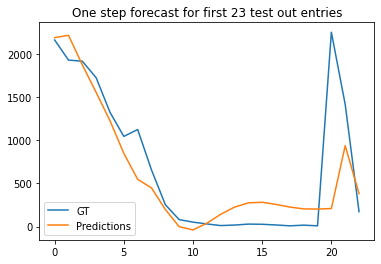

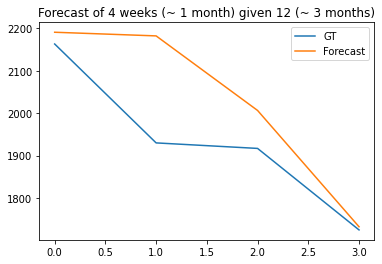

RMSE value: 483.37870608277115
MAE value: 272.01061082922894


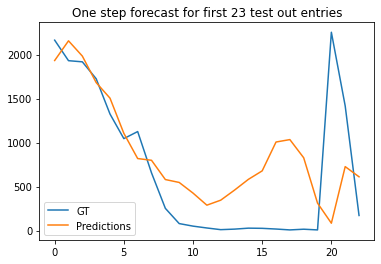

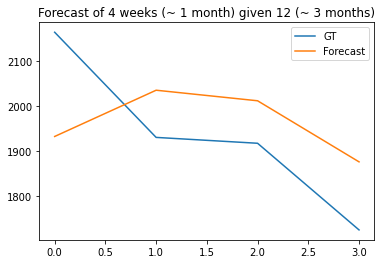

RMSE value: 658.9343384983491
MAE value: 482.38073863153875
Default training and test sets dimensions:
 (160, 3) (40, 3)
Augmented training and test sets dimensions:
 (160, 14) (40, 14)


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


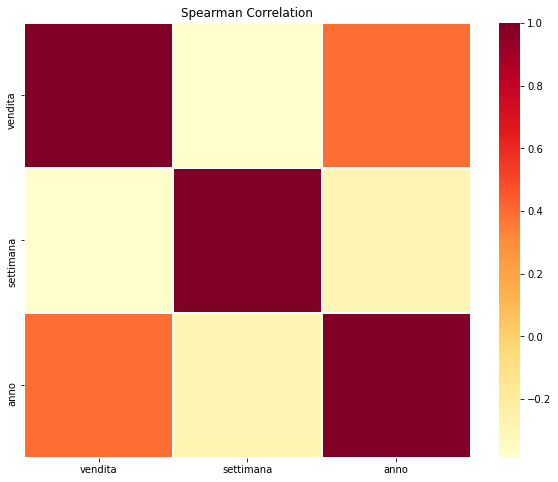

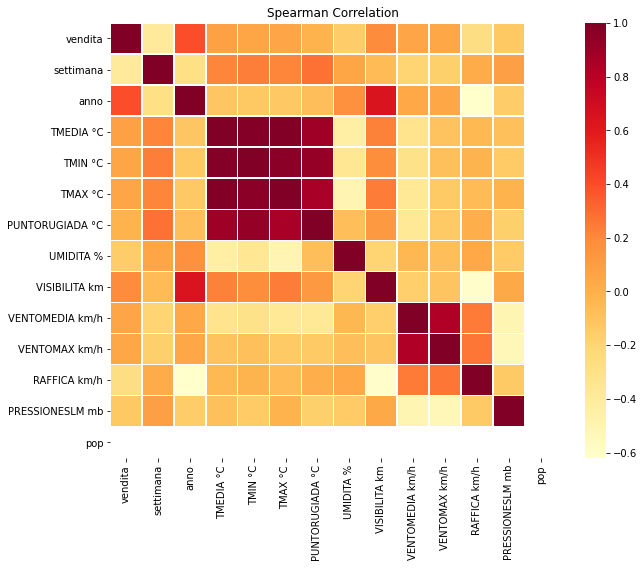

Default input features: [0, 1, 2]
Input features with augmented data: [0, 1, 2, 7, 8, 11, 12]
Inputs for training
(144, 12, 3)
Outputs for training
(144, 4, 3)
Inputs for testing
(24, 12, 3)
Outputs for testing
(24, 4, 3)


Inputs for training
(144, 12, 7)
Outputs for training
(144, 4, 7)
Inputs for testing
(24, 12, 7)
Outputs for testing
(24, 4, 7)



Training the default model
Epoch 1 Train loss: 0.86. Validation loss: 0.73. Avg future: 3.74. Elapsed time: 0.45s.
Epoch 2 Train loss: 0.66. Validation loss: 0.51. Avg future: 4.29. Elapsed time: 0.46s.
Epoch 3 Train loss: 0.47. Validation loss: 0.39. Avg future: 4.20. Elapsed time: 0.47s.
Epoch 4 Train loss: 0.38. Validation loss: 0.34. Avg future: 3.89. Elapsed time: 0.46s.
Epoch 5 Train loss: 0.33. Validation loss: 0.30. Avg future: 3.51. Elapsed time: 0.46s.
Epoch 6 Train loss: 0.29. Validation loss: 0.27. Avg future: 4.31. Elapsed time: 0.46s.
Epoch 7 Train loss: 0.27. Validation loss: 0.25. Avg future: 3.89. Elapsed time: 0.45s.
Ep

Epoch 39 Train loss: 0.31. Validation loss: 0.31. Avg future: 4.23. Elapsed time: 0.46s.
Epoch 40 Train loss: 0.31. Validation loss: 0.31. Avg future: 3.89. Elapsed time: 0.45s.
Epoch 41 Train loss: 0.30. Validation loss: 0.31. Avg future: 4.00. Elapsed time: 0.47s.
Epoch 42 Train loss: 0.31. Validation loss: 0.31. Avg future: 3.66. Elapsed time: 0.44s.
Epoch 43 Train loss: 0.30. Validation loss: 0.31. Avg future: 3.51. Elapsed time: 0.46s.
Epoch 44 Train loss: 0.30. Validation loss: 0.31. Avg future: 4.06. Elapsed time: 0.47s.
Epoch 45 Train loss: 0.30. Validation loss: 0.31. Avg future: 3.71. Elapsed time: 0.47s.
Epoch 46 Train loss: 0.30. Validation loss: 0.31. Avg future: 3.77. Elapsed time: 0.45s.
Epoch 47 Train loss: 0.30. Validation loss: 0.31. Avg future: 4.37. Elapsed time: 0.45s.
Epoch 48 Train loss: 0.31. Validation loss: 0.30. Avg future: 3.66. Elapsed time: 0.45s.
Epoch 49 Train loss: 0.30. Validation loss: 0.30. Avg future: 3.43. Elapsed time: 0.48s.
Epoch 50 Train loss: 

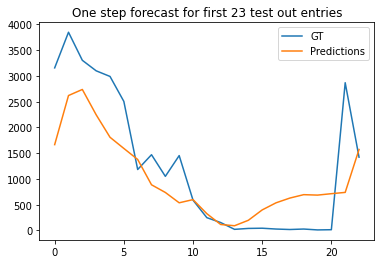

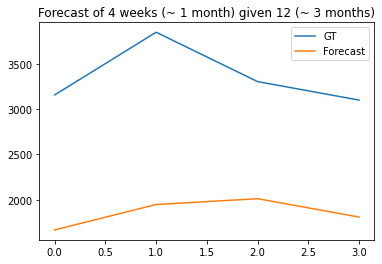

RMSE value: 814.204961374109
MAE value: 637.8260879516602


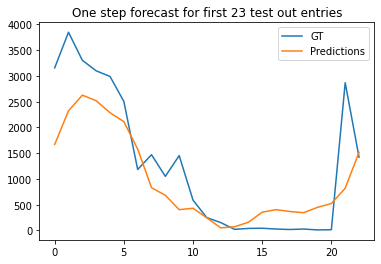

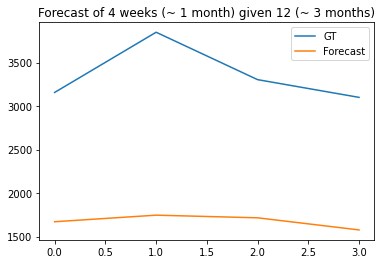

RMSE value: 763.6113134101287
MAE value: 571.4892171223959


In [18]:
forecasting_eval_metrics = {}
for dataset in aug_datasets:
    # Load the default and augmented versions of the data
    aug_dataset = aug_datasets[dataset]
    def_dataset = def_datasets[dataset]
        
    # Create training and test data
    def_train, def_test = ts_train_test_split(def_dataset)
    aug_train, aug_test = ts_train_test_split(aug_dataset)
    
    def_tr_df, def_te_df = prepare_for_network(def_train, def_test)
    aug_tr_df, aug_te_df = prepare_for_network(aug_train, aug_test)
    print("Default training and test sets dimensions:\n", def_tr_df.shape, def_te_df.shape)
    print("Augmented training and test sets dimensions:\n", aug_tr_df.shape, aug_te_df.shape)
    
    ## Correlation matrix: Spearman Correlation
    # Default data
    default_s_corr = def_tr_df.corr(method="spearman")
    plt.figure(figsize=(10,8))
    sns.heatmap(data=default_s_corr, cmap="YlOrRd", linewidths=.5)
    plt.title("Spearman Correlation")
    plt.show()

    # Augmented data
    aug_s_corr = aug_tr_df.corr(method="spearman")
    plt.figure(figsize=(10,8))
    sns.heatmap(data=aug_s_corr, cmap="YlOrRd", linewidths=.5)
    plt.title("Spearman Correlation")
    plt.show()

    # Extract the columns which display most correlation with the value we are trying to predict
    default_desired_input_features = cols_with_most_corr(default_s_corr, 0)
    aug_desired_input_features = cols_with_most_corr(aug_s_corr, 0)
    print("Default input features:", default_desired_input_features)
    print("Input features with augmented data:", aug_desired_input_features)
    
    def_inp_tr, def_out_tr, def_inp_te, def_out_te = build_in_out_seq(def_tr_df, def_te_df, default_desired_input_features)
    aug_inp_tr, aug_out_tr, aug_inp_te, aug_out_te = build_in_out_seq(aug_tr_df, aug_te_df, aug_desired_input_features)
    
    # Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
    def_x_train=torch.cat((torch.Tensor(def_inp_tr),torch.Tensor(def_out_tr)),1)
    def_x_test=torch.Tensor(def_inp_te)
    aug_x_train=torch.cat((torch.Tensor(aug_inp_tr),torch.Tensor(aug_out_tr)),1)
    aug_x_test=torch.Tensor(aug_inp_te)
    
    
    # Define the two LSTM Models and Optimizer objects (one for the default data and the other for the augmented)
    # First create the LSTM Model that will be used for forecasting
    loss_fn = nn.MSELoss()
    
    def_LSTM_Model = Model(input_size=len(default_desired_input_features), hidden_size=80, output_size=len(default_desired_input_features))
    def_optimizer = optim.Adam(def_LSTM_Model.parameters(), lr=1e-3)
    def_scheduler = optim.lr_scheduler.StepLR(optimizer=def_optimizer, step_size=25, gamma=0.1)
    def_opt_obj = Optimization(def_LSTM_Model, loss_fn, def_optimizer, def_scheduler)
    
    aug_LSTM_Model = Model(input_size=len(aug_desired_input_features), hidden_size=80, output_size=len(aug_desired_input_features))
    aug_optimizer = optim.Adam(aug_LSTM_Model.parameters(), lr=1e-3)
    aug_scheduler = optim.lr_scheduler.StepLR(optimizer=aug_optimizer, step_size=25, gamma=0.1)
    aug_opt_obj = Optimization(aug_LSTM_Model, loss_fn, aug_optimizer, aug_scheduler)
    
    # Default training
    print("\nTraining the default model")
    def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=50)
    print("\nTraining the augmented model")
    aug_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=50)
    
    def_pred=def_LSTM_Model(def_x_test, 4)
    aug_pred=aug_LSTM_Model(aug_x_test, 4)
    
    # Check results of both forecasts
    def_mean = np.mean(def_train["vendita"].values)
    def_std = np.std(def_train["vendita"].values)
    def_rmse, def_mae = check_forecast_results(def_pred, def_inp_te, def_out_te, def_mean, def_std)
    aug_mean = np.mean(aug_train["vendita"].values)
    aug_std = np.std(aug_train["vendita"].values)
    aug_rmse, aug_mae = check_forecast_results(aug_pred, aug_inp_te, aug_out_te, aug_mean, aug_std)
    
    # Save results
    forecasting_eval_metrics[dataset+"-def-RMSE"] = def_rmse
    forecasting_eval_metrics[dataset+"-def-MAE"] = def_mae
    forecasting_eval_metrics[dataset+"-aug-RMSE"] = aug_rmse
    forecasting_eval_metrics[dataset+"-aug-MAE"] = aug_mae

In [19]:
forecasting_eval_metrics

{'Milan-def-RMSE': 540.803052333852,
 'Milan-def-MAE': 398.9249108355978,
 'Milan-aug-RMSE': 524.7893005787864,
 'Milan-aug-MAE': 344.77616417926293,
 'Turin-def-RMSE': 483.37870608277115,
 'Turin-def-MAE': 272.01061082922894,
 'Turin-aug-RMSE': 658.9343384983491,
 'Turin-aug-MAE': 482.38073863153875,
 'Rome-def-RMSE': 814.204961374109,
 'Rome-def-MAE': 637.8260879516602,
 'Rome-aug-RMSE': 763.6113134101287,
 'Rome-aug-MAE': 571.4892171223959}